<a href="https://colab.research.google.com/github/Jeffrowetull/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/DS_Unit_2_Sprint_Challenge_4_Practicing_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [311]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51916 entries, 0 to 51915
Data columns (total 17 columns):
Inspection ID      51916 non-null int64
DBA Name           51916 non-null object
AKA Name           51293 non-null object
License #          51911 non-null float64
Facility Type      51692 non-null object
Risk               51904 non-null object
Address            51916 non-null object
City               51863 non-null object
State              51906 non-null object
Zip                51890 non-null float64
Inspection Date    51916 non-null object
Inspection Type    51915 non-null object
Violations         42261 non-null object
Latitude           51718 non-null float64
Longitude          51718 non-null float64
Location           51718 non-null object
Fail               51916 non-null int64
dtypes: float64(4), int64(2), object(11)
memory usage: 6.7+ MB


In [312]:
train.describe(include='number')

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
count,5.191600e+04,5.191100e+04,51890.000000,51718.000000,51718.000000,51916.000000
mean,1.330265e+06,1.549491e+06,60628.834669,41.879568,-87.676663,0.258610
std,6.202664e+05,9.018283e+05,22.736963,0.081126,0.059509,0.437875
min,4.425000e+04,0.000000e+00,60007.000000,41.644670,-87.914428,0.000000
25%,6.796205e+05,1.140745e+06,60614.000000,41.830296,-87.707857,0.000000
50%,1.424226e+06,1.958619e+06,60625.000000,41.890166,-87.666524,0.000000
75%,1.946952e+06,2.215507e+06,60643.000000,41.939167,-87.634461,1.000000
max,2.279709e+06,8.700606e+06,60827.000000,42.021064,-87.525094,1.000000


In [313]:
train.describe(exclude='number')

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Violations,Location
count,51916,51293,51692,51904,51916,51863,51906,51916,51915,42261,51718
unique,17049,16350,329,3,13954,39,1,2257,51,42164,13410
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,2017-03-23T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,"{'longitude': '-87.91442843927047', 'latitude'..."
freq,654,802,34264,37731,741,51659,51906,50,24170,3,741


In [314]:
train.isna().sum().sort_values()

Inspection ID         0
Inspection Date       0
Address               0
Fail                  0
DBA Name              0
Inspection Type       1
License #             5
State                10
Risk                 12
Zip                  26
City                 53
Location            198
Latitude            198
Longitude           198
Facility Type       224
AKA Name            623
Violations         9655
dtype: int64

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._



In [315]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [316]:
from sklearn.model_selection import train_test_split
train_null = train.dropna()
X_train = train_null.drop(columns= 'Fail')
y_train = train_null.Fail

X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, stratify=y_train)

y_train.value_counts(normalize=True)


0    0.709549
1    0.290451
Name: Fail, dtype: float64

In [317]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
majority=y_train.mode()[0]
y_pred=[majority]*len(y_val)
print('accuracy:',accuracy_score(y_val,y_pred))
print('rocauc:',roc_auc_score(y_val,y_pred))

accuracy: 0.7095132955745416
rocauc: 0.5


In [318]:
from sklearn.tree import DecisionTreeClassifier

X_train_numeric = X_train.select_dtypes('number').drop(columns='Inspection ID')
X_val_numeric = X_val.select_dtypes('number').drop(columns='Inspection ID')

tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train_numeric, y_train)
y_pred_proba = tree.predict_proba(X_val_numeric)[:,1]

roc_auc_score(y_val,y_pred_proba)

0.5689757232295973

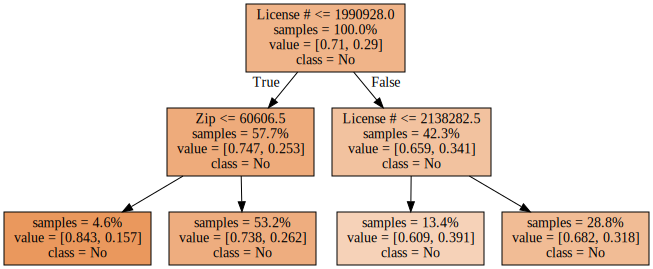

In [319]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None, feature_names=X_train_numeric.columns, 
                           class_names=['No', 'Yes'], filled=True, impurity=False, proportion=True)

graphviz.Source(dot_data)

Despite this tree listing Liscence and inspection ID, I think that the leaky feature is violations because you wouldn't know your violations until after the inspection occured and specific violations will fail you. These specific violations are future knowledge of whether the inspections have failed or not.

In [0]:
train = train.drop(columns='Violations')
test = test.drop(columns='Violations')

In [321]:
train.head(1)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1


In [322]:
train['Inspection Date'].astype(str)

0        2017-09-15T00:00:00
1        2011-10-20T00:00:00
2        2016-04-05T00:00:00
3        2016-04-29T00:00:00
4        2011-01-10T00:00:00
5        2016-02-22T00:00:00
6        2017-01-12T00:00:00
7        2013-05-07T00:00:00
8        2014-11-28T00:00:00
9        2011-06-01T00:00:00
10       2015-11-30T00:00:00
11       2011-04-04T00:00:00
12       2017-02-10T00:00:00
13       2011-10-21T00:00:00
14       2015-12-10T00:00:00
15       2017-08-01T00:00:00
16       2014-01-17T00:00:00
17       2010-10-20T00:00:00
18       2014-11-20T00:00:00
19       2016-10-18T00:00:00
20       2011-04-15T00:00:00
21       2014-06-06T00:00:00
22       2018-10-31T00:00:00
23       2018-03-29T00:00:00
24       2016-02-16T00:00:00
25       2016-12-15T00:00:00
26       2015-07-07T00:00:00
27       2017-02-21T00:00:00
28       2018-04-17T00:00:00
29       2011-11-01T00:00:00
                ...         
51886    2016-11-29T00:00:00
51887    2014-08-28T00:00:00
51888    2018-01-17T00:00:00
51889    2014-

In [0]:
def wrangle(X):
  X = X.copy()
  
  #drop things
  X = X.drop(columns =['Inspection ID','AKA Name','License #','Location', 'State' ] )
  
  #make a datetime
  X['Inspection Date'] = X['Inspection Date'].str.rstrip('0:T')
  X['Inspection Date'] = pd.to_datetime(train['Inspection Date'], infer_datetime_format=True)
  X['Weekday'] = X['Inspection Date'].dt.weekday_name
  
  #drop time because it can't go into the model
  X['Inspection Date'] = X['Inspection Date'].astype(str)
     
  #fill nulls
  X[['Inspection Type', 'Risk','Facility Type']] = X[['Inspection Type', 'Risk','Facility Type']].fillna('N/A')
  X['City'] = X['City'].fillna('CHICAGO')
  
  
  for col in X:
    if X[col].isnull().sum() > 0:
      X[col] = X[col].fillna(X[col].mean())
      
  return X

train = wrangle(train)
test = wrangle(test)

In [325]:
risk = train['Risk'].str.extract('(?P<digit>\d)').fillna(4).astype(int)
risk['digit'].unique()

array([1, 3, 2, 4])

In [0]:
def risk(X):
  X =X.copy()
  
  #encode risk
  X['Risk']= X['Risk'].str.extract('(?P<digit>\d)').fillna(4).astype(int)
  
  return X

train = risk(train)
test = risk(test)

In [327]:
train.head()

,DBA Name,Facility Type,Risk,Address,City,Zip,Inspection Date,Inspection Type,Latitude,Longitude,Fail,Weekday
0,"TOM YUM RICE & NOODLE, INC.",Restaurant,1,608 W BARRY,CHICAGO,60657.0,2017-09-15,Canvass,41.938007,-87.644755,1,Friday
1,FILLING STATION & CONVENIENCE STORE,Grocery Store,3,6646-6658 S WESTERN AVE,CHICAGO,60636.0,2011-10-20,Complaint Re-Inspection,41.772402,-87.683603,0,Thursday
2,A P DELI,Restaurant,1,2025 E 75TH ST,CHICAGO,60649.0,2016-04-05,Canvass Re-Inspection,41.758779,-87.575054,0,Tuesday
3,FRANK'S CHICAGO SHRIMP HOUSE,Restaurant,2,4459 S ARCHER AVE,CHICAGO,60632.0,2016-04-29,Canvass,41.812181,-87.707125,0,Friday
4,MORRILL,School,1,6011 S Rockwell (2600W) AVE,CHICAGO,60629.0,2011-01-10,Canvass,41.879568,-87.676663,0,Monday


In [328]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51916 entries, 0 to 51915
Data columns (total 12 columns):
DBA Name           51916 non-null object
Facility Type      51916 non-null object
Risk               51916 non-null int64
Address            51916 non-null object
City               51916 non-null object
Zip                51916 non-null float64
Inspection Date    51916 non-null object
Inspection Type    51916 non-null object
Latitude           51916 non-null float64
Longitude          51916 non-null float64
Fail               51916 non-null int64
Weekday            51916 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 4.8+ MB


In [329]:
pip install category_encoders

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._




In [0]:
X_train = train.drop(columns='Fail')
y_train = train.Fail

X_test = test.drop(columns='Fail')
y_test = test.Fail

In [331]:
X_train

,DBA Name,Facility Type,Risk,Address,City,Zip,Inspection Date,Inspection Type,Latitude,Longitude,Weekday
0,"TOM YUM RICE & NOODLE, INC.",Restaurant,1,608 W BARRY,CHICAGO,60657.0,2017-09-15,Canvass,41.938007,-87.644755,Friday
1,FILLING STATION & CONVENIENCE STORE,Grocery Store,3,6646-6658 S WESTERN AVE,CHICAGO,60636.0,2011-10-20,Complaint Re-Inspection,41.772402,-87.683603,Thursday
2,A P DELI,Restaurant,1,2025 E 75TH ST,CHICAGO,60649.0,2016-04-05,Canvass Re-Inspection,41.758779,-87.575054,Tuesday
3,FRANK'S CHICAGO SHRIMP HOUSE,Restaurant,2,4459 S ARCHER AVE,CHICAGO,60632.0,2016-04-29,Canvass,41.812181,-87.707125,Friday
4,MORRILL,School,1,6011 S Rockwell (2600W) AVE,CHICAGO,60629.0,2011-01-10,Canvass,41.879568,-87.676663,Monday
5,LAKEVIEW REHABILITATION AND NURSING CENTER,Long Term Care,1,735 W DIVERSEY PKWY,CHICAGO,60614.0,2016-02-22,Canvass,41.932632,-87.647973,Monday
6,GOLD COAST DOGS,Restaurant,2,225 S CANAL ST,CHICAGO,60606.0,2017-01-12,Canvass,41.878531,-87.639427,Thursday
7,HAPPY PIZZA,Restaurant,1,8710 S HALSTED ST,CHICAGO,60620.0,2013-05-07,License Re-Inspection,41.735505,-87.643749,Tuesday
8,THE PUMPING CO INC,Restaurant,1,6157 N BROADWAY,CHICAGO,60660.0,2014-11-28,Canvass,41.993973,-87.660242,Friday
9,YUMMY YUMMY NOODLES,Restaurant,1,2002 S WENTWORTH AVE,CHICAGO,60616.0,2011-06-01,License,41.855282,-87.631993,Wednesday


In [332]:
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=2, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    5.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.1s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcb6b0c74e0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcb574fc710>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [333]:
print('cross-val rocauc:',search.best_score_)

cross-val rocauc: 0.6828904816900562


In [0]:
best = search.best_estimator_

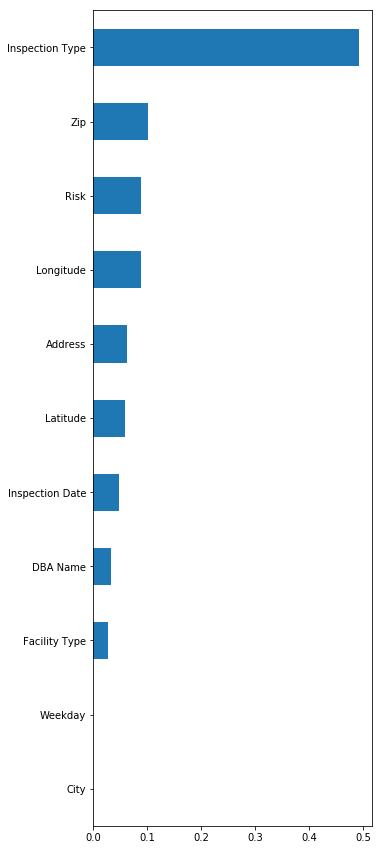

In [335]:
n = len(X_train.columns)
figsize = (5,15)
importances = pd.Series(best.feature_importances_,X_train.columns)
top_n = importances.sort_values()[-n:]
plt.figure(figsize=figsize)
top_n.plot.barh();

In [336]:
pip install eli5

In [337]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='roc_auc', cv='prefit', n_iter=2,
                               random_state=24)

permuter.fit(X_train.values, y_train)

PermutationImportance(cv='prefit',
           estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=64,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
           n_iter=2, random_state=24, refit=True, scoring='roc_auc')

In [338]:
feature_names = X_train.columns.tolist()

eli5.show_weights(permuter, top=None,feature_names=feature_names)

Weight,Feature
0.1610 ± 0.0050,Inspection Type
0.0148 ± 0.0011,Zip
0.0031 ± 0.0002,Longitude
0.0025 ± 0.0005,Latitude
0.0024 ± 0.0005,Risk
0.0017 ± 0.0001,DBA Name
0.0010 ± 0.0003,Address
0.0007 ± 0.0000,Inspection Date
0.0006 ± 0.0000,Facility Type
0 ± 0.0000,Weekday


In [339]:
print('shape before removing features:',X_train.shape)
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
print('shape after removing',X_train.shape)

shape before removing features: (51916, 11)
shape after removing (51916, 9)


In [340]:
param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}


search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=24), 
    param_distributions=param_distributions, 
    n_iter=2, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    4.4s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.7s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=24, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcb557b2f28>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcb557b2c88>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [341]:
print('Cross-Validation ROC AUC:', search.best_score_)

Cross-Validation ROC AUC: 0.6828904816900562


In [342]:
best = search.best_estimator_
X_test = encoder.transform(X_test)
X_test = X_test[features]
y_pred_proba = best.predict_proba(X_test)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.6866713863813589


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._



In [343]:
pip install pdpbox

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcb544e2358>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcb64c44828>})

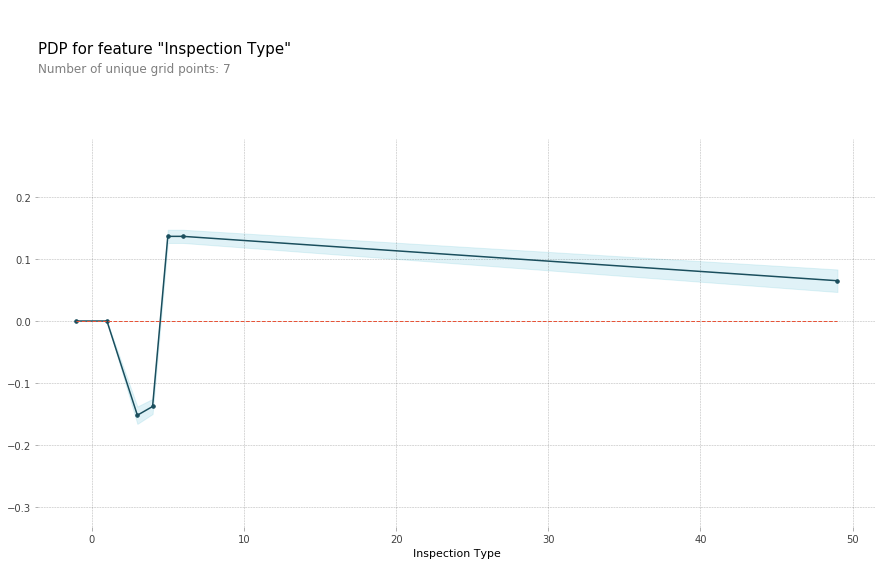

In [344]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Inspection Type'

isolated = pdp_isolate(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    feature = feature
    
)
pdp_plot(isolated,feature_name=feature)

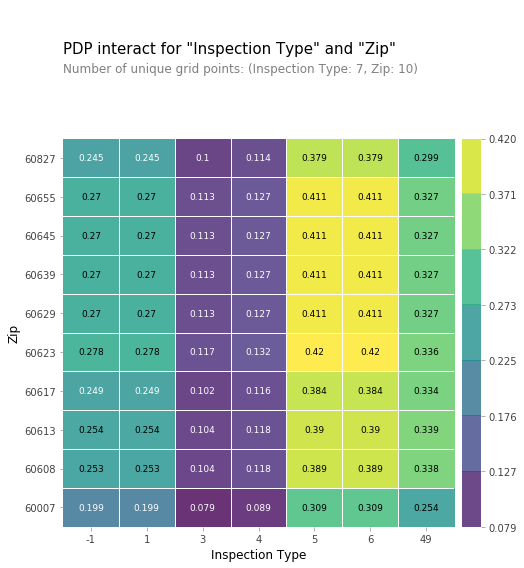

In [345]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Inspection Type', 'Zip']

interactions = pdp_interact(
  model=best,
dataset=X_test,
model_features=X_test.columns,
features=features
)
pdp_interact_plot(interactions, plot_type='grid', feature_names=features);

In [346]:
threshold=.3
y_pred = (y_pred_proba >= threshold).astype(int)
confidence = np.abs(y_pred_proba - threshold)
preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 
                      'y_pred_proba': y_pred_proba, 
                      'confidence': confidence})

preds.head(10)

,y_test,y_pred,y_pred_proba,confidence
0,0,0,0.222141,0.077859
1,0,0,0.275912,0.024088
2,0,0,0.233770,0.066230
3,1,0,0.103930,0.196070
4,1,1,0.302035,0.002035
5,0,0,0.264146,0.035854
6,1,1,0.383043,0.083043
7,0,0,0.102876,0.197124
8,0,0,0.250837,0.049163
9,1,0,0.268939,0.031061


In [347]:
pip install shap

In [348]:
data_for_prediction=X_test[X_test.index==4]
import shap 
shap.initjs()

explainer = shap.TreeExplainer(best)
shap_values= explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value,shap_values,data_for_prediction)

In [349]:
data_for_prediction=X_test[X_test.index==3]
import shap 
shap.initjs()

explainer = shap.TreeExplainer(best)
shap_values= explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value,shap_values,data_for_prediction)

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

Gradient descent seeks to minimize the residuals and the instantaneous slope. After finding and plotting the sum of square errors, I find that it is a parabola. Because it's values are squared. Going along that line and by finding the point that reduces the instantaneous slope (gradient) to zero will give you the ideal placement for your line because it will have the best distance from the datapoints.

Learning rate is the distance at which the thing travels down the gradient, starting out large when the gradient is large and getting smaller as the slope approaches zero in order not to overshoot the minimum.